### 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import time
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb
from math import radians, cos, sin, asin, sqrt
from tqdm import tqdm, tqdm_notebook
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import math
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import json
import gc
import re
warnings.filterwarnings('ignore')

d:\programfiles2\anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import os
# os.chdir('/cos_person/ChinaCom/CCF/WorkPiece/data')
train = pd.read_csv('../data/first_round_training_data.csv')
test = pd.read_csv('../data/first_round_testing_data.csv')

In [4]:
len(train),len(test)

(6000, 6000)

In [5]:
train.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,...,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,...,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


In [36]:
train.nunique()

Parameter1       6000
Parameter2       6000
Parameter3       6000
Parameter4       6000
Parameter5        132
Parameter6         80
Parameter7         14
Parameter8         23
Parameter9         16
Parameter10        41
Attribute1       6000
Attribute2       6000
Attribute3       6000
Attribute4        600
Attribute5        553
Attribute6        394
Attribute7        702
Attribute8        565
Attribute9        626
Attribute10       565
Quality_label       4
IStrain             1
dtype: int64

####  第一次的开源中尝试直接用nunique观察匿名数据来判定一些具备类别特性的字段，尝试将其当作类别去看待，类别特征天生的离散属性，包含的不仅仅自己本身取值的意义，所以发现这样的字段是非常有意思的；不过前面这种做法还是有点粗糙，這次我们尝试多个角度观察问题，看看是否有新的发现


In [9]:
train['IStrain'] = 1
test['IStrain'] = 0
data = pd.concat([train,test])


In [12]:
train_mask = data.IStrain==1
test_mask =  data.IStrain==0

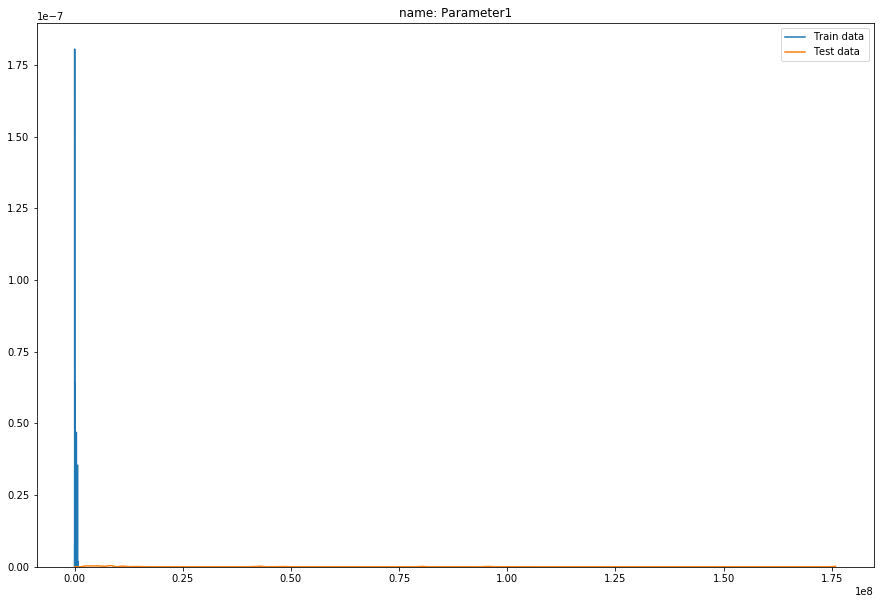

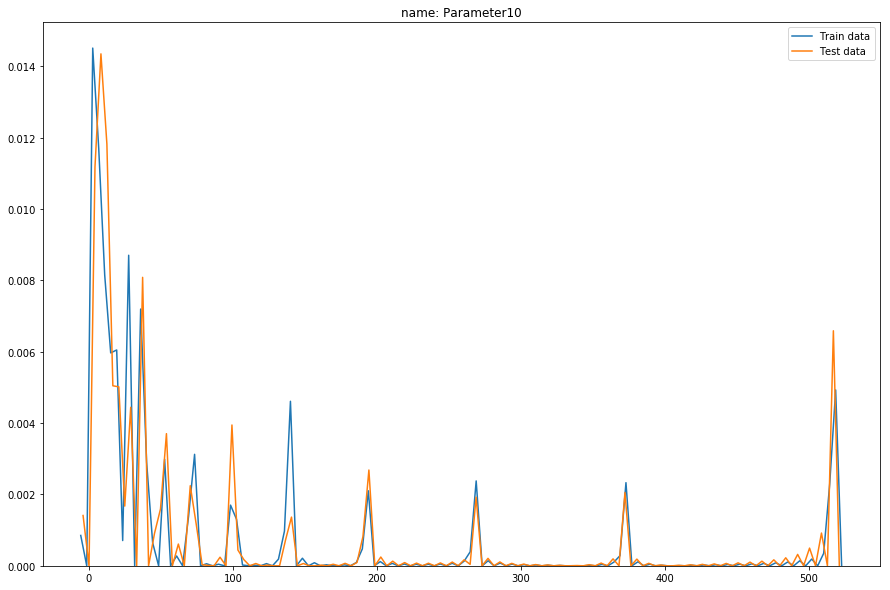

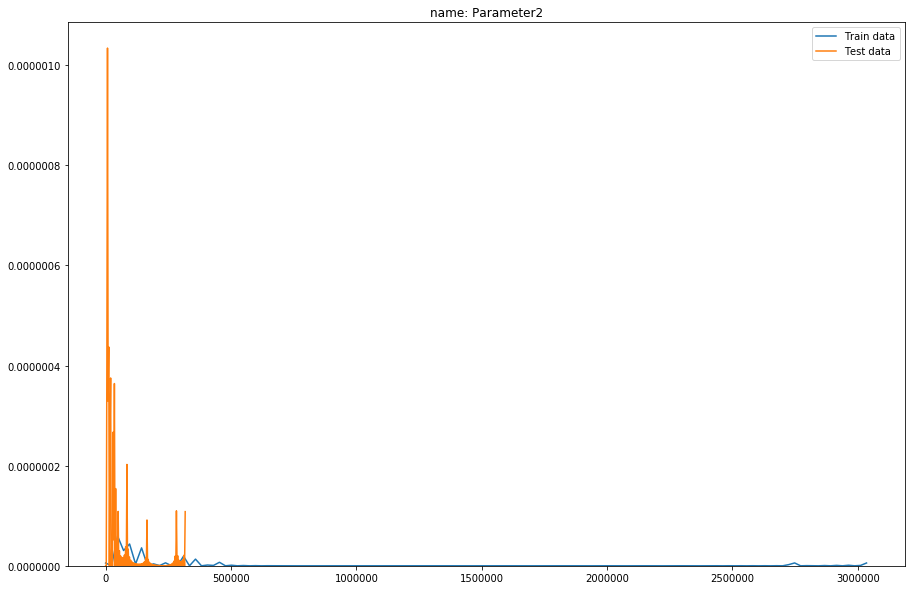

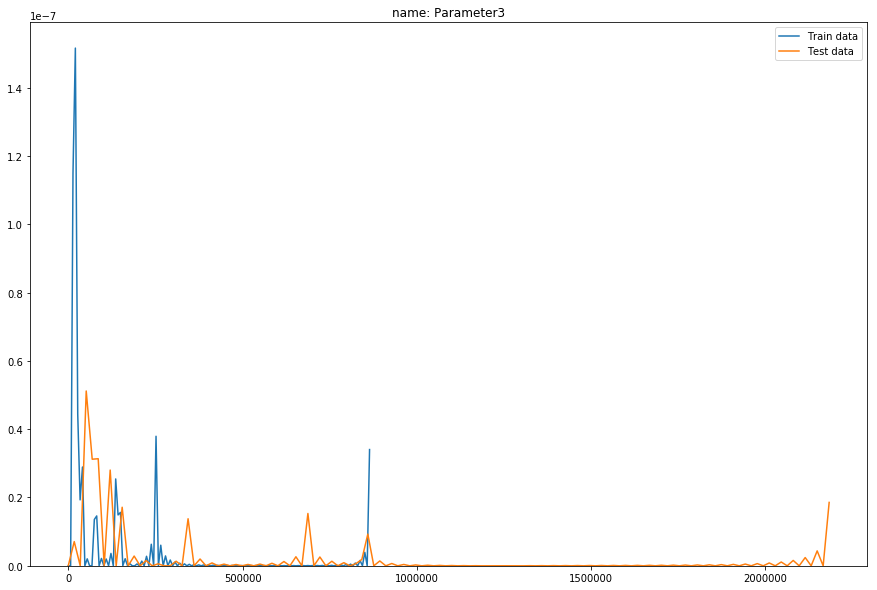

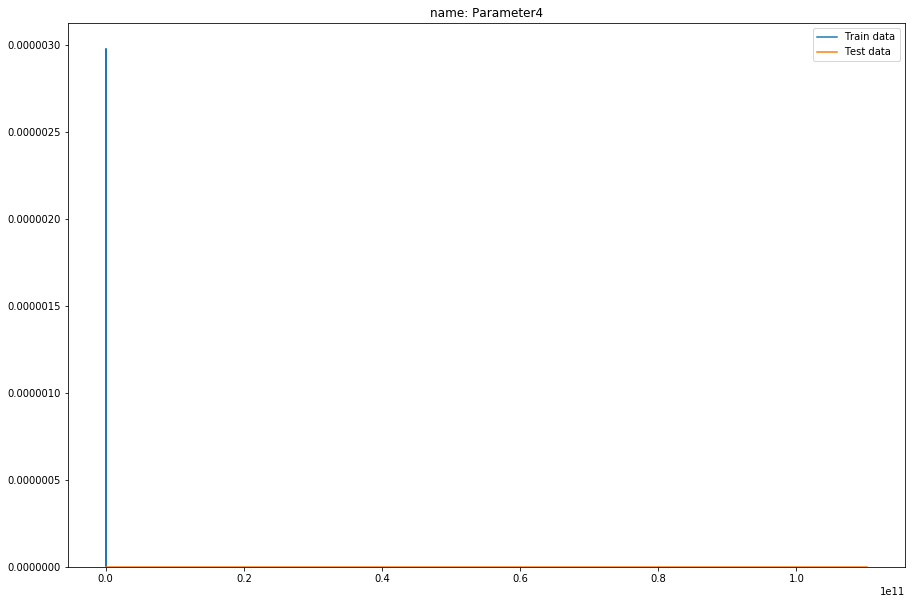

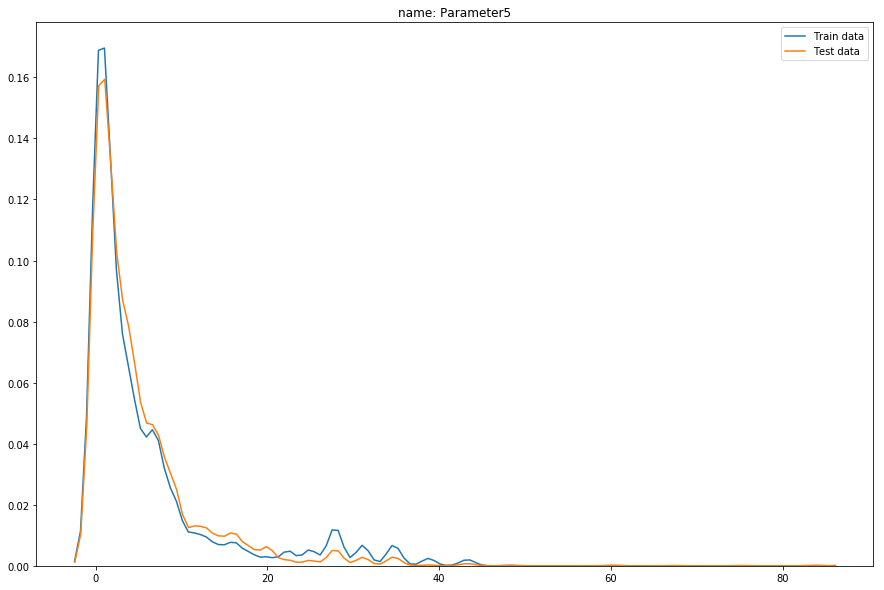

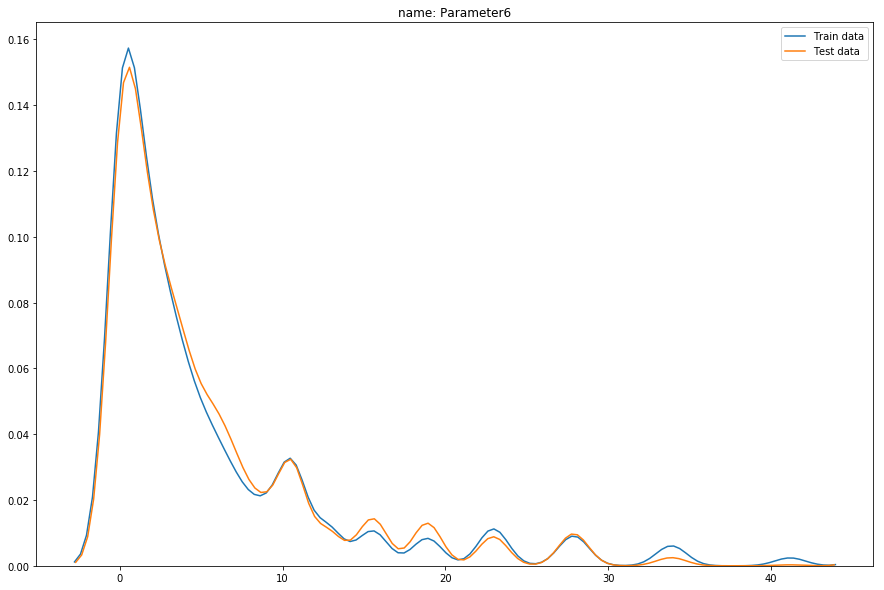

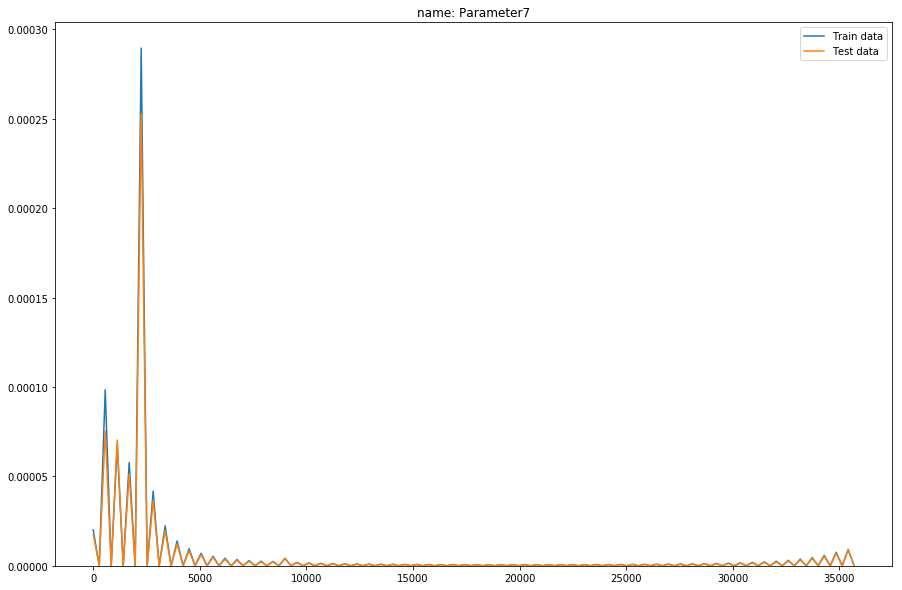

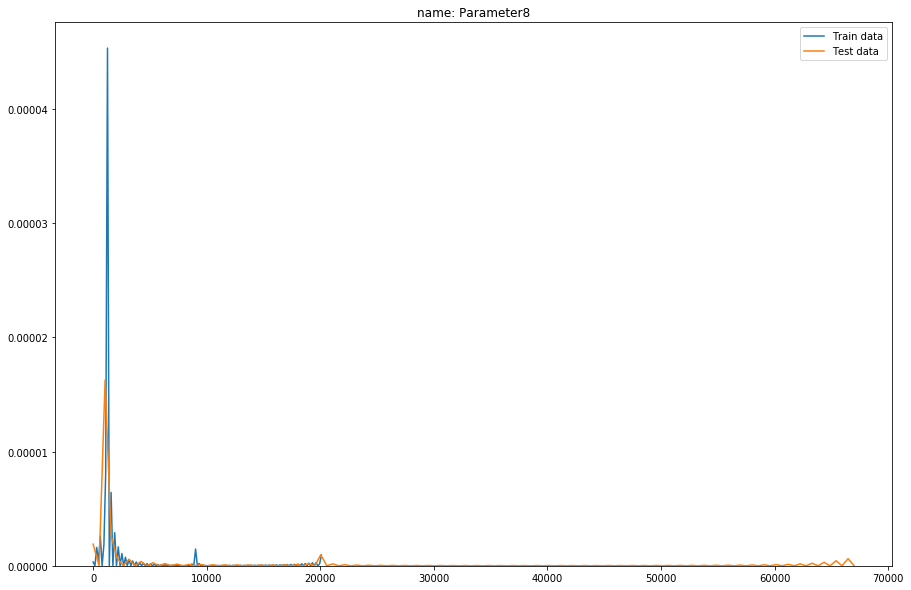

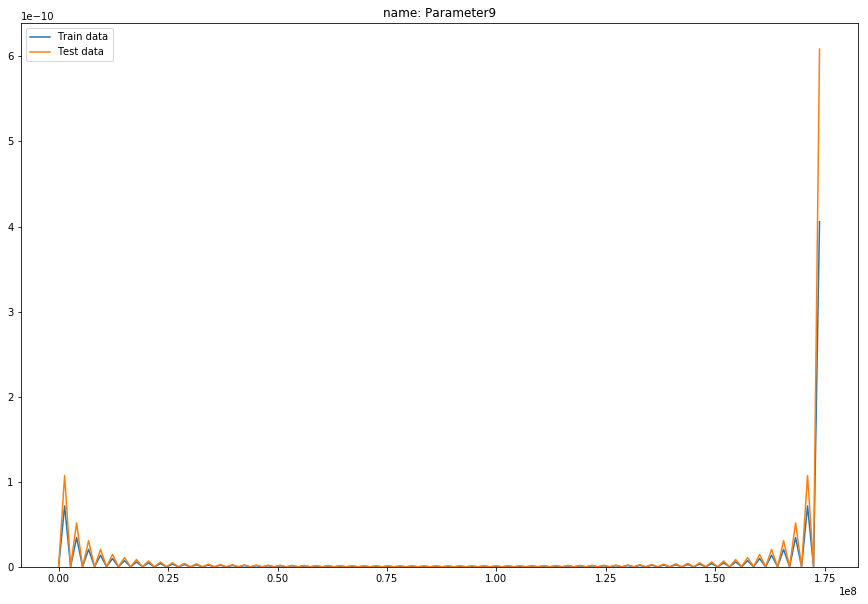

In [16]:
for col in test.columns:
    if col in ['IStrain','Group']:
        continue
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    sns.kdeplot(data.loc[train_mask, col], ax=ax, label='Train data')
    sns.kdeplot(data.loc[test_mask, col], ax=ax, label='Test data')

    ax.set_title('name: {}'.format(col))
    plt.show()
    

#### （额外，跟发现类别特征无关的但是必须观察的图）通过上面的kde图我们发现一些诡异的分布行为，比如 Parameter1 Parameter2 Parameter4 字段很明显的存在一个分布覆盖另一个分布形态，也就是分布是有那么点不一致的 

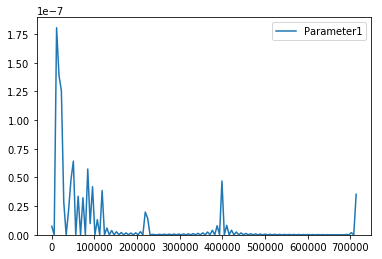

In [19]:
# Parameter1
# Parameter2
# Parameter4
sns.kdeplot(train.Parameter1)


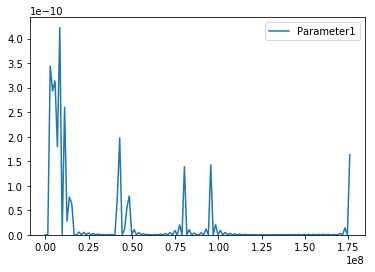

In [37]:
sns.kdeplot(test.Parameter1)

#### 两张图上能看出取值上还是有一点异样的地方，但是不是很明显，暂时放一边

In [23]:
data = data.reset_index()
# 12000

In [25]:
data = data.rename(columns={'index':'indexCol'})

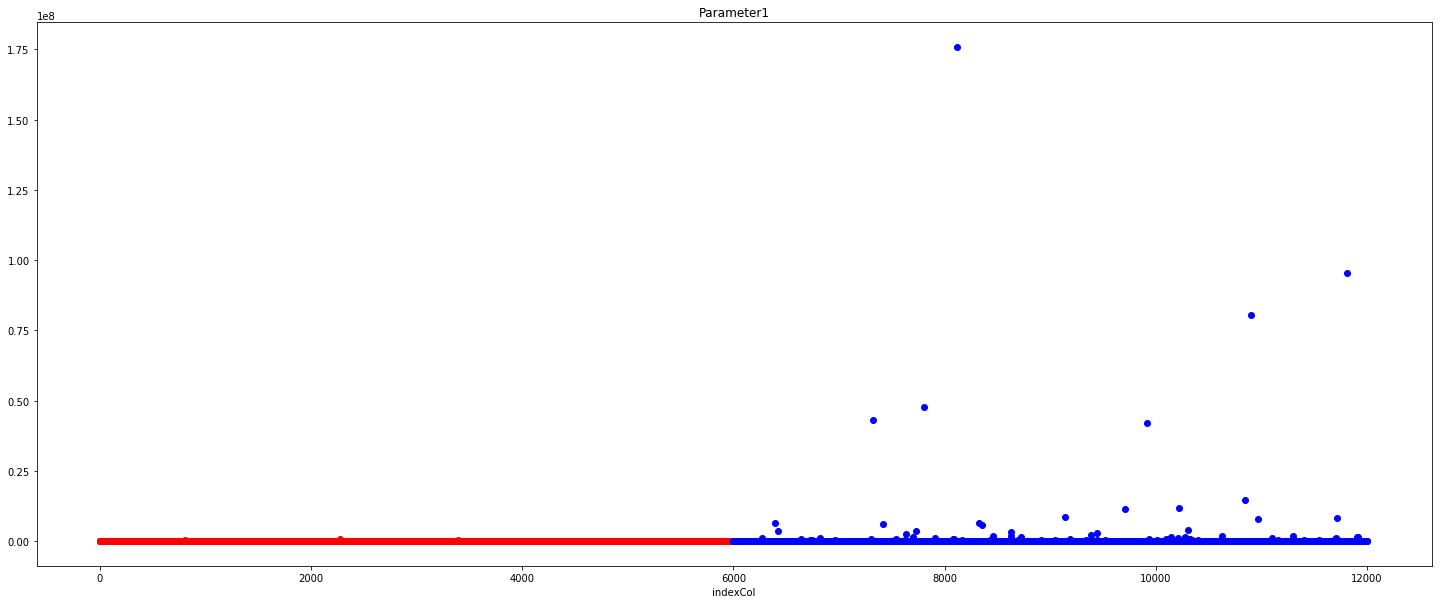

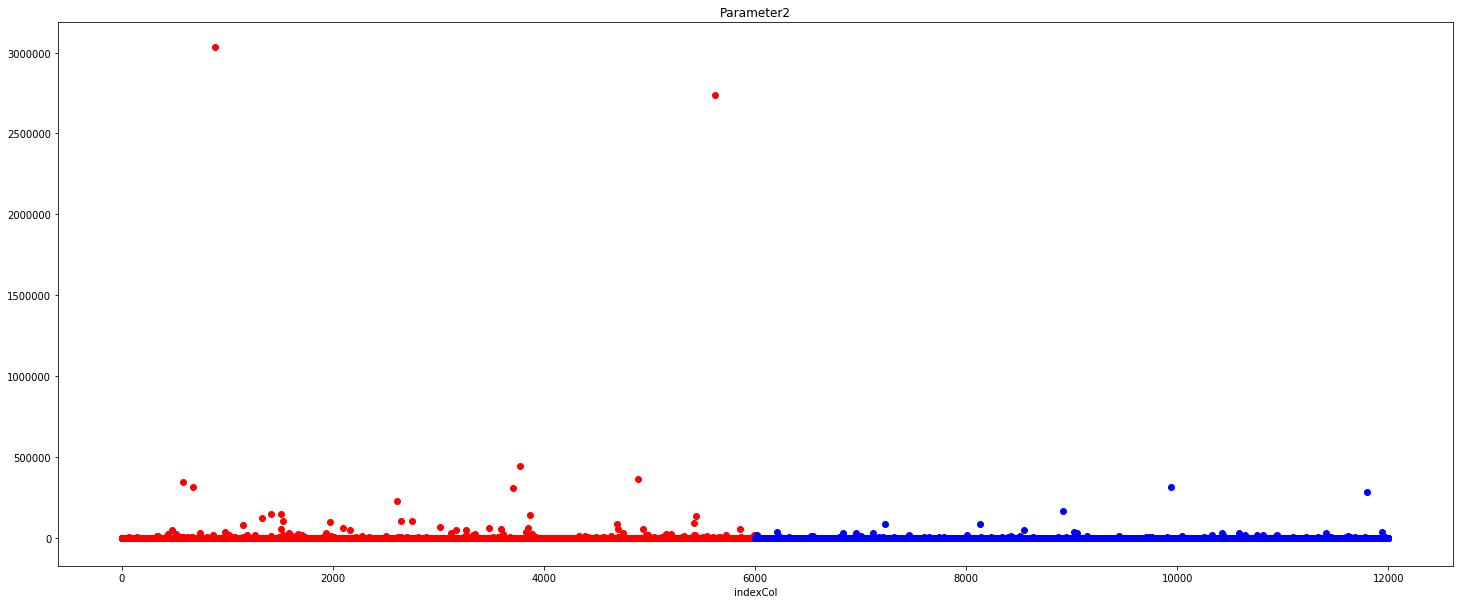

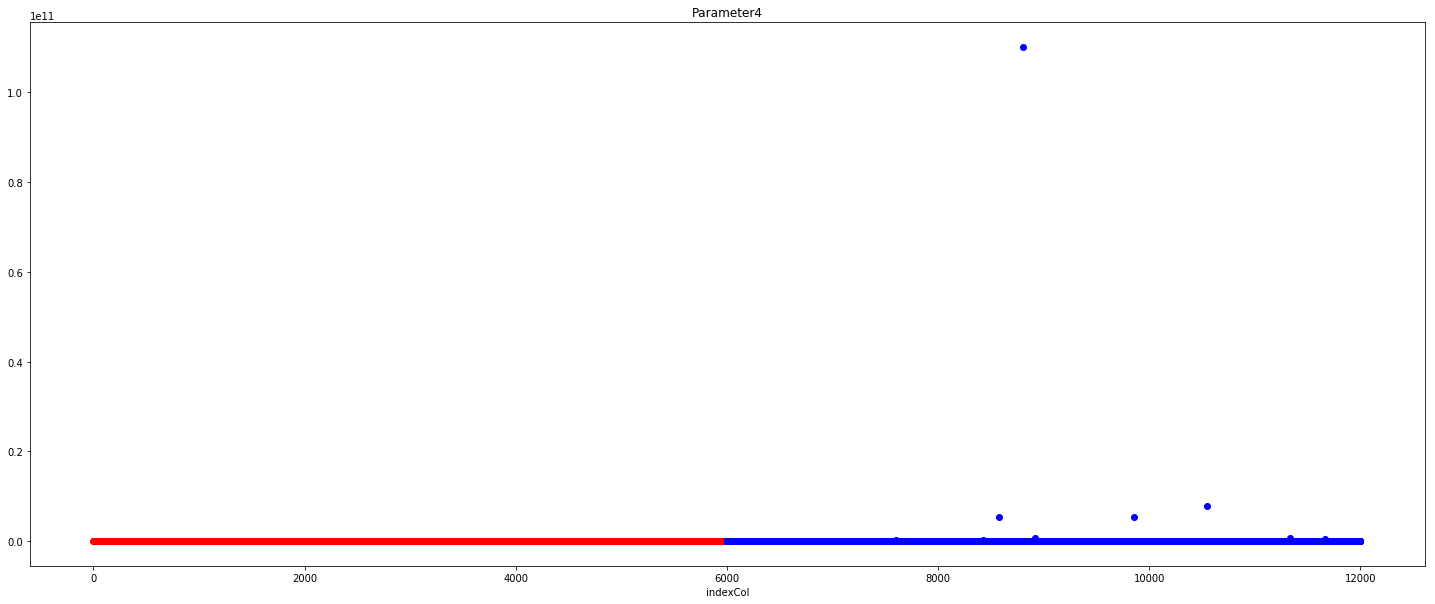

In [27]:
# sns.kdeplot(test.Parameter1)
V_Cols = ['Parameter1','Parameter2','Parameter4']
for col in V_Cols:
    plt.figure(figsize=(25, 10))
    plt.scatter(data.loc[data.IStrain==1,'indexCol'], data.loc[data.IStrain==1,col], color='r')
    plt.scatter(data.loc[data.IStrain==0,'indexCol'], data.loc[data.IStrain==0,col], color='b')
    plt.xlabel('indexCol')
    plt.title(col)
    plt.show()


### emmm比较明显，存在一些异常点，是噪音数据

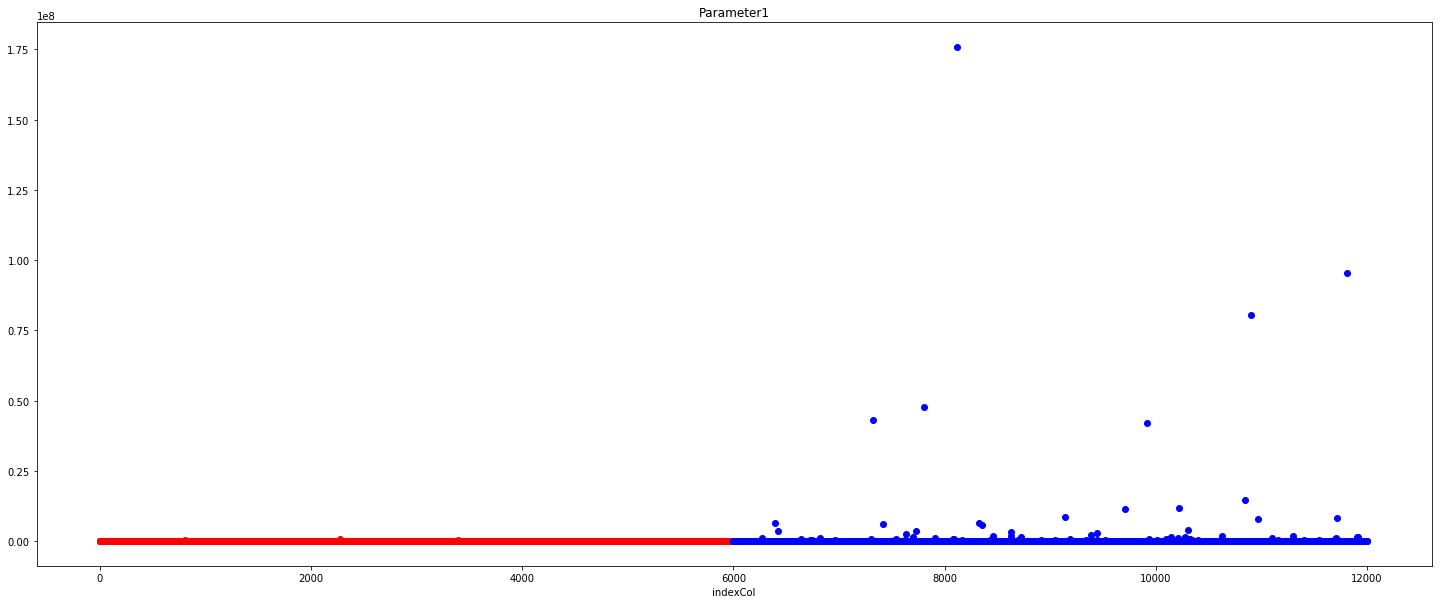

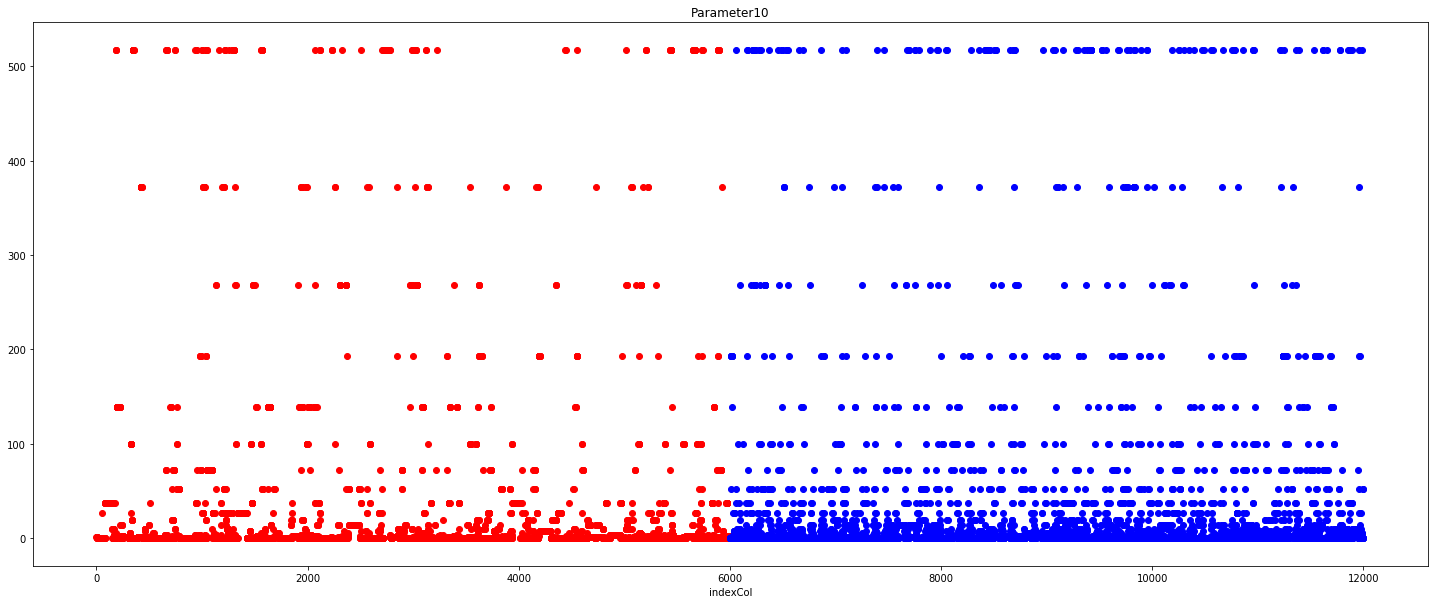

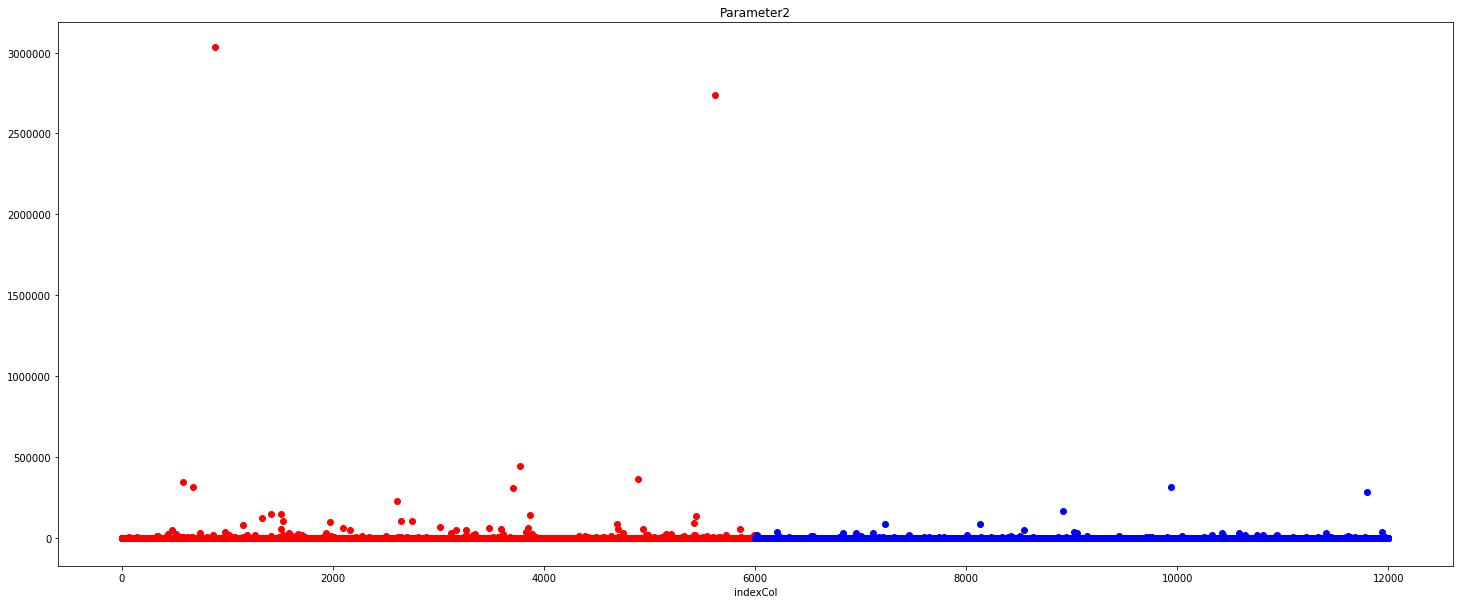

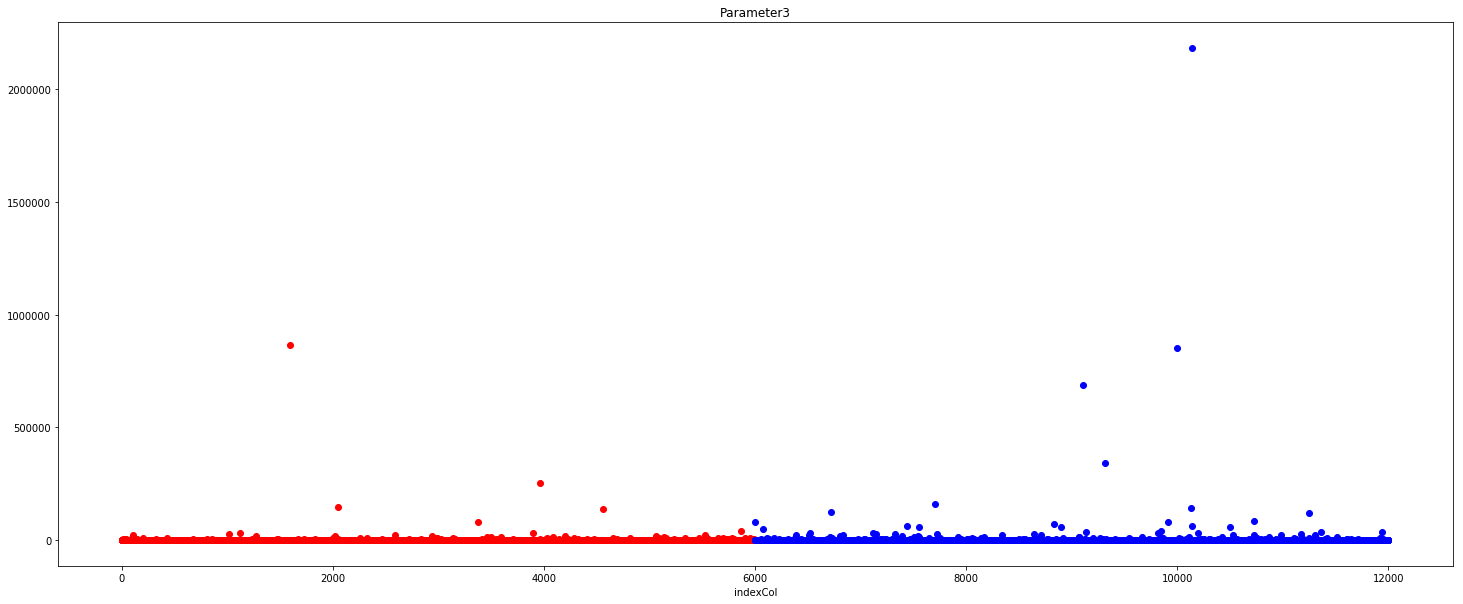

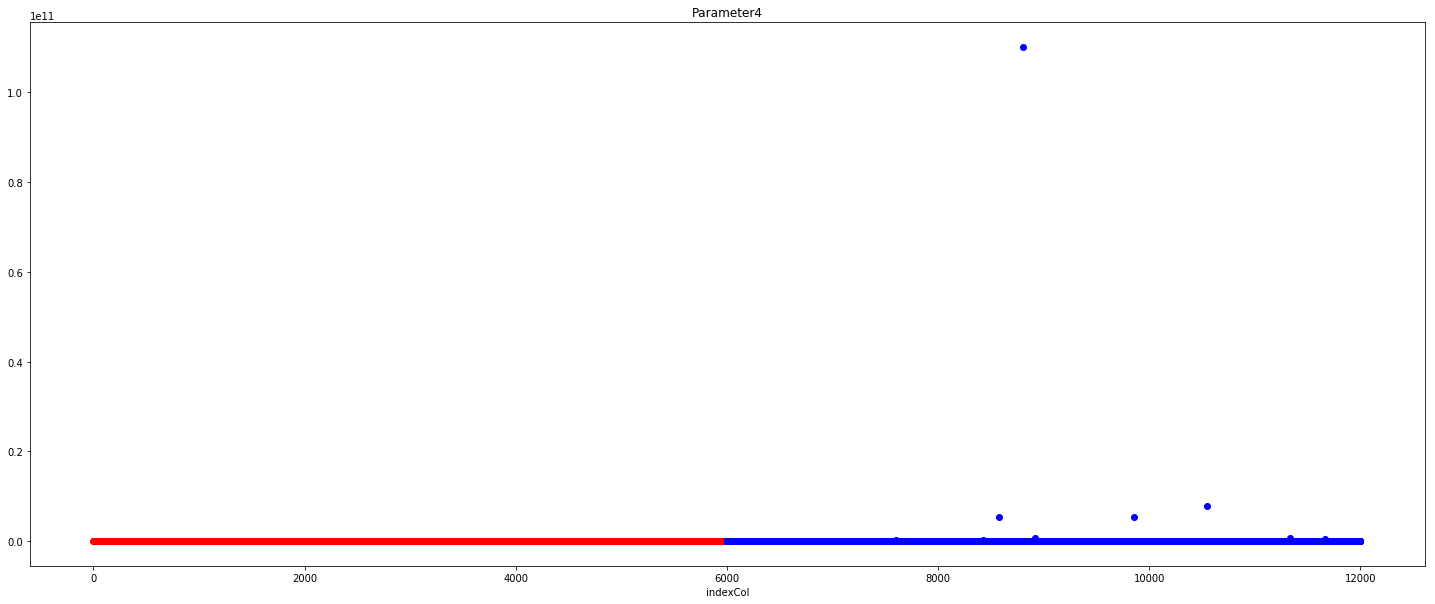

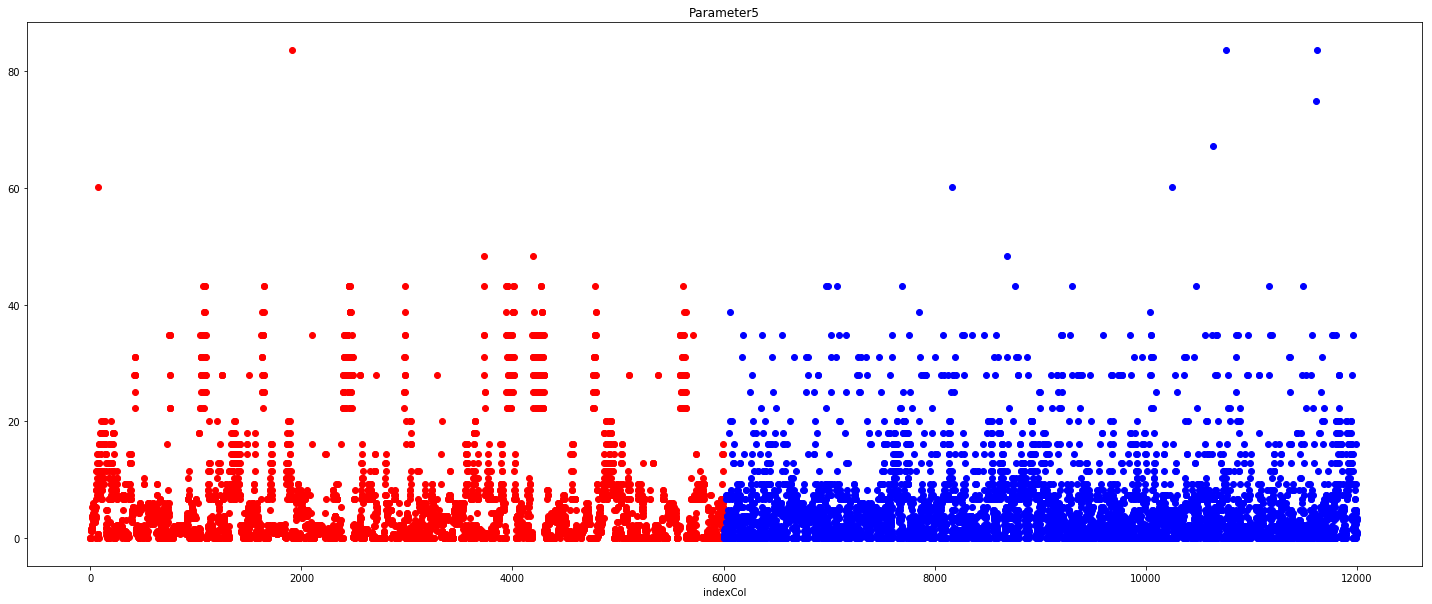

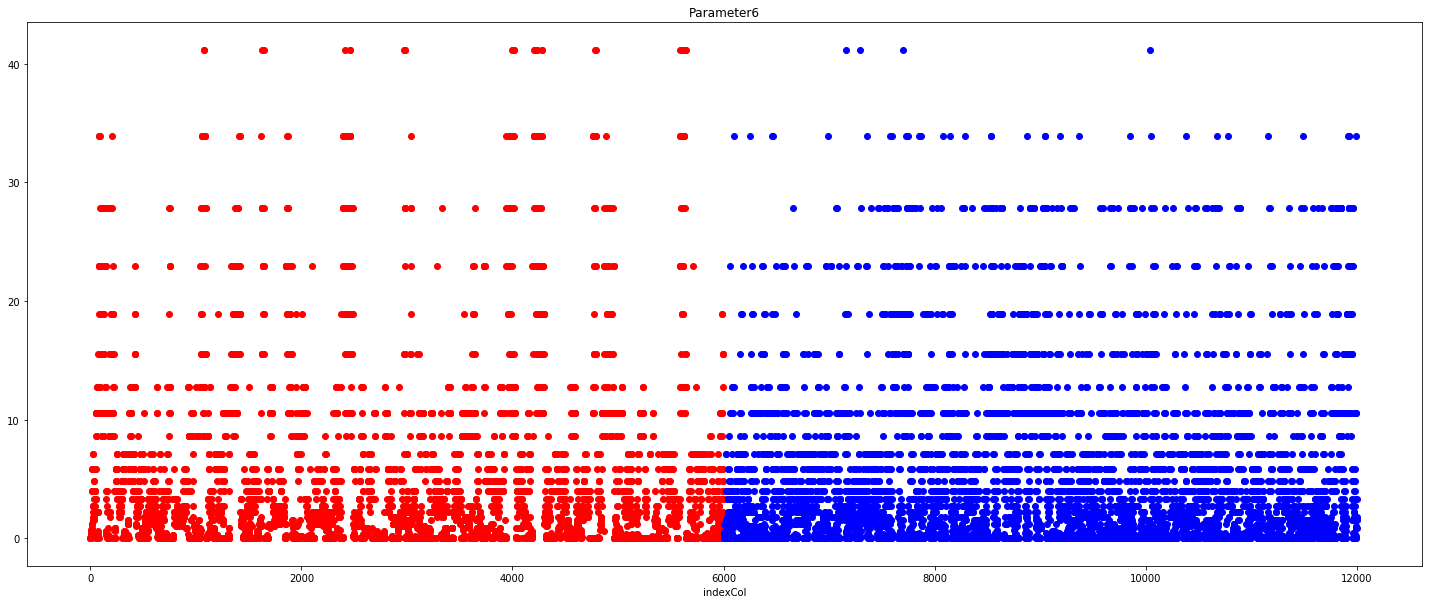

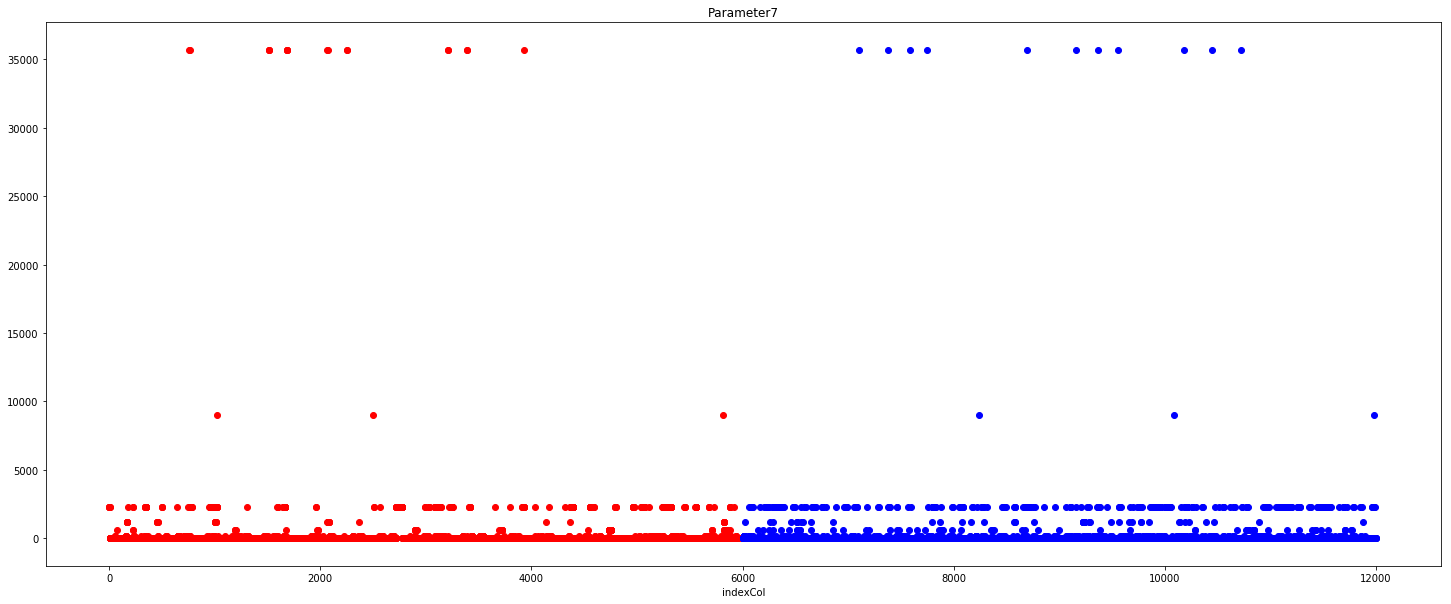

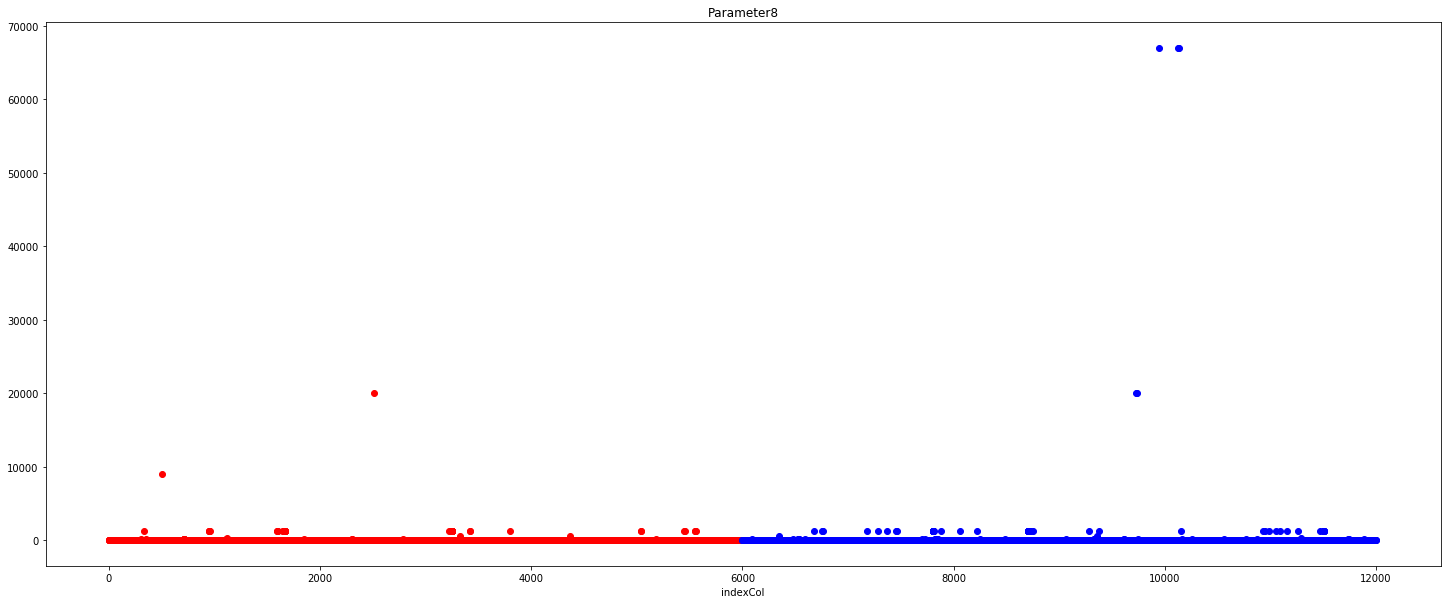

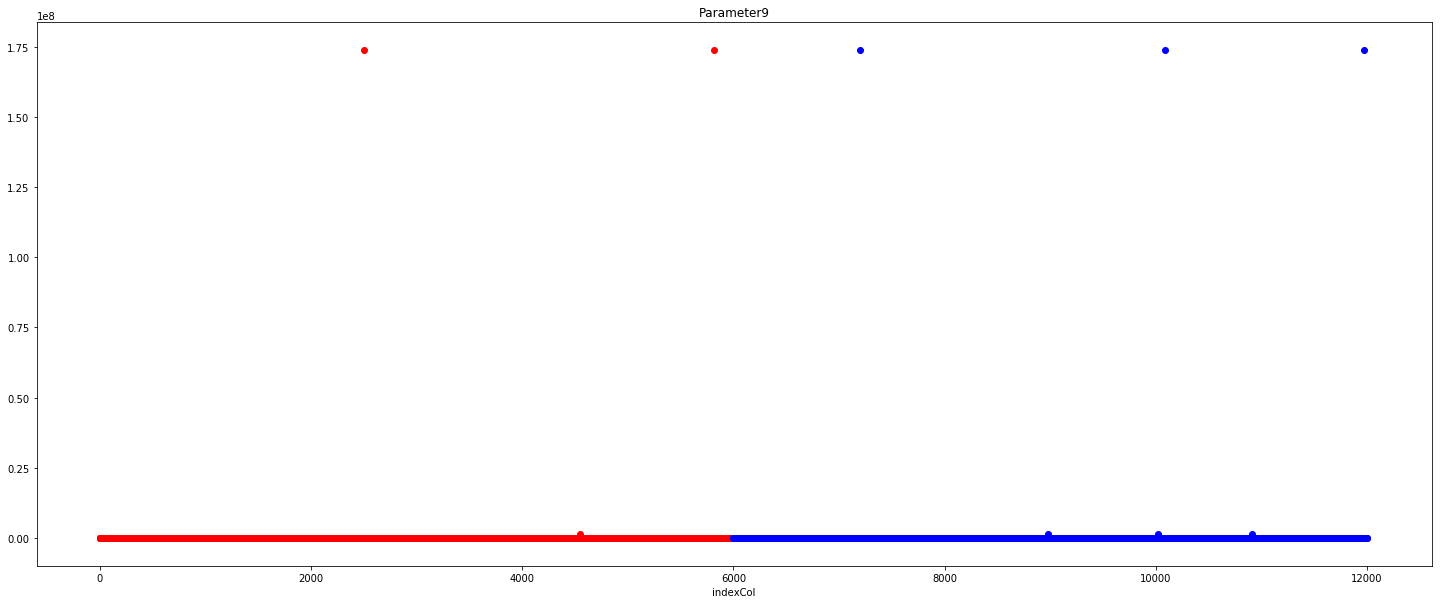

In [28]:
# sns.kdeplot(test.Parameter1)
V_Cols = [c for c in test.columns if 'Param' in c]
for col in V_Cols:
    plt.figure(figsize=(25, 10))
    plt.scatter(data.loc[data.IStrain==1,'indexCol'], data.loc[data.IStrain==1,col], color='r')
    plt.scatter(data.loc[data.IStrain==0,'indexCol'], data.loc[data.IStrain==0,col], color='b')
    plt.xlabel('indexCol')
    plt.title(col)
    plt.show()


### 这个图应该是专门为了寻找类别特征而打造的，没错，我们认真观察发现5/6 这个两个参数特征，分布上具备纹路的足够”类别“的类别特征！！！ 这就是我们想看到，并且利用的信息

In [30]:
train.Parameter9.value_counts().index

Float64Index([     0.593081227289144,      6.783966877714622,
                 0.05184950759684327,      887.6112567119349,
                0.004532889112547222,       77.5984881671055,
                  2.0058522881119365,      262.4448353482133,
              0.00039628310198070463,     22.943965949381422,
                  173808298.30160776,     1328407.8247474495,
                  116134.66829117713,     10152.952224341356,
                   16529.74868995182,       4887.44046504319],
             dtype='float64')

In [31]:
train.Parameter9.value_counts()

5.930812e-01    2833
6.783967e+00    1180
5.184951e-02     856
8.876113e+02     302
4.532889e-03     191
7.759849e+01     164
2.005852e+00     153
2.624448e+02     134
3.962831e-04     131
2.294397e+01      49
1.738083e+08       2
1.328408e+06       1
1.161347e+05       1
1.015295e+04       1
1.652975e+04       1
4.887440e+03       1
Name: Parameter9, dtype: int64

In [32]:
train.Parameter7.value_counts()

0.152059        2004
0.600827        1533
2.374035         887
0.038483         495
146.453658       406
2286.523413      350
37.064872        103
578.679288        90
0.002465          41
1150.288546       39
9.380474          29
35698.591553      18
9034.692324        3
0.000624           2
Name: Parameter7, dtype: int64

In [34]:
# train.Parameter5.value_counts()

Parameter1       6000
Parameter2       6000
Parameter3       6000
Parameter4       6000
Parameter5        132
Parameter6         80
Parameter7         14
Parameter8         23
Parameter9         16
Parameter10        41
Attribute1       6000
Attribute2       6000
Attribute3       6000
Attribute4        600
Attribute5        553
Attribute6        394
Attribute7        702
Attribute8        565
Attribute9        626
Attribute10       565
Quality_label       4
IStrain             1
dtype: int64